# <h1 style="text-align: center;">Identifying Top Films 

## Project Overview

This project conducts a **comprehensive analysis of the movie industry** by integrating multiple data sources including IMDb, Box Office data, TMDB, Rotten Tomatoes, and budget information. The goal is to uncover actionable insights that can guide strategic decision-making for stakeholders in the film industry, such as:

- **Production Companies**: Understanding which genres, budgets, and release strategies maximize profitability
- **Investors**: Identifying risk factors and high-return investment opportunities
- **Marketing Teams**: Recognizing patterns in audience ratings and box office performance
- **Content Creators**: Discovering trends in successful films across different markets

## Business Objectives

### Primary Objectives:

1. **Profitability Analysis**: Determine the relationship between production budgets and box office returns
2. **Market Comparison**: Analyze domestic vs. international market performance
3. **Studio Performance**: Evaluate which studios consistently deliver profitable films
4. **Genre Analysis**: Identify which movie genres perform best in terms of ratings and revenue
5. **Rating Impact**: Assess the correlation between audience ratings and financial success
6. **Temporal Trends**: Examine how the movie industry has evolved over time

### Key Questions:

- Is there a significant difference between domestic and foreign gross revenues?
- Do higher production budgets guarantee higher profits?
- Which studios are most profitable on average?
- What is the relationship between IMDb ratings and box office performance?
- How do different genres perform across various metrics?
- Are there temporal patterns in movie profitability and ratings?

---

## Data Sources

| Dataset | Source | Key Information |
|---------|--------|----------------|
| **movie_basics** | IMDb (SQLite) | Movie titles, genres, runtime, release year |
| **movie_ratings** | IMDb (SQLite) | User ratings and vote counts |
| **movie_gross** | Box Office Mojo | Domestic and foreign gross revenue |
| **tmdb** | The Movie Database | Popularity scores, vote averages, release dates |
| **movie_budgets** | The Numbers | Production budgets and worldwide gross |


---

## Methodology

The analysis follows a structured approach:

1. **Data Loading**: Import all datasets from various sources
2. **Data Cleaning**: Handle missing values, convert data types, standardize formats
3. **Feature Engineering**: Create derived metrics and normalize titles for merging
4. **Data Integration**: Merge datasets on common keys (titles, IDs)
5. **Exploratory Data Analysis (EDA)**: Visualize distributions and relationships
6. **Statistical Testing**: Conduct hypothesis tests to validate findings
7. **Insights & Recommendations**: Synthesize results into actionable insights

---

In [353]:
#importing relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
import sqlite3
from sqlalchemy import create_engine
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import ttest_ind, ttest_1samp, chi2_contingency, norm

from sklearn.preprocessing import StandardScaler, LabelEncoder

import os
import pickle



# plotting defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,8)
sns.set(style="whitegrid", rc={"figure.dpi":100})

## Data Loading  

We begin by loading all datasets:
- SQLite database (`im.db`) containing IMDb-like tables.  
- CSV/TSV files providing box office, TMDB, Rotten Tomatoes, and budget information.  

These diverse sources will later be merged into a unified dataset for analysis.


In [299]:
budgets = pd.read_csv("../Data/tn.movie_budgets.csv", low_memory=False)
tmdb = pd.read_csv("../Data/tmdb.movies.csv", low_memory=False)
bom = pd.read_csv('../Data/bom.movie_gross.csv', low_memory=False)

In [300]:
#check columns
print(budgets.columns)
print(tmdb.columns)
print(bom.columns)

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')
Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')
Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')


#### Loading the `im.db` sqlite database

In [301]:
#connect to the database
conn = sqlite3.connect("../Data/im.db")
tables= pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print( "Tables in im.db:")
print(tables)
tables.columns = ['name']

Tables in im.db:
            name
0   movie_basics
1      directors
2      known_for
3     movie_akas
4  movie_ratings
5        persons
6     principals
7        writers


In [302]:
movie_basics = pd.read_sql_query("SELECT * FROM movie_basics;", conn)
movie_ratings = pd.read_sql_query("SELECT * FROM movie_ratings;", conn)

## Data cleaning

### 1. `tbmd.movies.csv` read as `tmbd`

In [303]:
tmdb.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [304]:
print(tmdb.info())
print(tmdb.isnull().sum())
tmdb.dropna(inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB
None
Unnamed: 0           0
genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64


## Steps:
Ensure `release_date` is datetime and extract the year.

Clean the `title` column (lowercase, trimmed).

Missing values.

Keep only relevant columns for analysis.

In [305]:
#converting data types to datetime
tmdb['release_date'] = pd.to_datetime(tmdb['release_date'],errors='coerce')
 
 #extracting year from release_date
tmdb['release_year'] = tmdb['release_date'].dt.year

#clean title 
tmdb['title_clean'] = tmdb['title'].str.lower().str.strip()

#Drop duplicates
tmdb.drop_duplicates(subset=['title_clean','release_year'], keep='first', inplace=True)

#drop unnamed
tmdb.drop(columns=['Unnamed: 0'],inplace=True)

#missing values to clean 
tmdb.isnull().sum()


genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
release_year         0
title_clean          0
dtype: int64

In [306]:
tmdb.duplicated().sum()

np.int64(0)

In [307]:
tmdb.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,release_year,title_clean
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,2010,harry potter and the deathly hallows: part 1
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,2010,how to train your dragon
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,2010,iron man 2
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,1995,toy story
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,2010,inception


### 2. `bom.movie_gross.csv` read as `bom`

In [308]:
bom.head(20)


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
5,The Twilight Saga: Eclipse,Sum.,300500000.0,398000000,2010
6,Iron Man 2,Par.,312400000.0,311500000,2010
7,Tangled,BV,200800000.0,391000000,2010
8,Despicable Me,Uni.,251500000.0,291600000,2010
9,How to Train Your Dragon,P/DW,217600000.0,277300000,2010


In [309]:
bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [310]:
#converting the foreign gross to numeric
bom['foreign_gross'] = pd.to_numeric(bom['foreign_gross'], errors='coerce') 

#drop missing row domestic_gross
bom.dropna(subset=['domestic_gross'], inplace=True)

#fill missing studio with 'unknown'
bom['studio'].fillna('unknown', inplace=True)

#changing data type to datetime
bom['year'] = pd.to_datetime(bom['year'])

# Fill missing foreign_gross with median (preserve 70%+)
median_foreign = bom['foreign_gross'].median()
bom['foreign_gross'].fillna(median_foreign, inplace=True)

#add total_gross column
bom['total_gross']=bom['domestic_gross']+bom['foreign_gross']


C:\Users\HP\AppData\Local\Temp\ipykernel_22336\3316764610.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bom['studio'].fillna('unknown', inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_22336\3316764610.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

In [311]:
bom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3359 entries, 0 to 3386
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   title           3359 non-null   object        
 1   studio          3359 non-null   object        
 2   domestic_gross  3359 non-null   float64       
 3   foreign_gross   3359 non-null   float64       
 4   year            3359 non-null   datetime64[ns]
 5   total_gross     3359 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 183.7+ KB


### 3. `tn.movie_budget.csv` read as `budgets`

In [312]:
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [313]:
budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


Remove `$` and `,` from the columns and convert to type Int64

Ensure `release_date` is datetime and extract the release_year.

Clean the `movie` column (lowercase, trimmed).

 generate the `profit`  column (`worldwide_gross`-`production_budget`)

In [314]:
# Remove dollar signs and commas
for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    budgets[col] = (
        budgets[col]
        .replace('[\$,]', '', regex=True)
        .astype(float)
    )
# Convert release_date to datetime
budgets['release_date'] = pd.to_datetime(budgets['release_date'], errors='coerce')

# Extract release year
budgets['release_year'] = budgets['release_date'].dt.year

# Clean movie title (lowercase, strip spaces)
budgets['movie_clean'] = budgets['movie'].str.lower().str.strip()

# Generate a `profit` column to determine net earnings by subtracting production costs from total revenues.
budgets['profit'] = budgets['worldwide_gross'] - budgets['production_budget']

# Profit ratio for The Numbers data
budgets['profit_ratio'] = budgets['worldwide_gross'] / budgets['production_budget']
budgets['profit_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Cap extreme outliers (values above 20 are rare in film data)
budgets['profit_ratio'] = budgets['profit_ratio'].clip(upper=20)

budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   float64       
 4   domestic_gross     5782 non-null   float64       
 5   worldwide_gross    5782 non-null   float64       
 6   release_year       5782 non-null   int32         
 7   movie_clean        5782 non-null   object        
 8   profit             5782 non-null   float64       
 9   profit_ratio       5782 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int32(1), int64(1), object(2)
memory usage: 429.3+ KB


C:\Users\HP\AppData\Local\Temp\ipykernel_22336\1714128166.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  budgets['profit_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)


### 4. `im.db` database 

In [315]:
movie_basics_ratings.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_clean,year,primary_genre
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,sunghursh,1970-01-01 00:00:00.000002013,Action
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43,one day before the rainy season,1970-01-01 00:00:00.000002019,Biography
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,the other side of the wind,1970-01-01 00:00:00.000002018,Drama
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119,the wandering soap opera,1970-01-01 00:00:00.000002017,Comedy
6,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",8.1,263,joe finds grace,1970-01-01 00:00:00.000002017,Adventure


In [316]:
movie_basics_ratings['title_clean'] = movie_basics_ratings['primary_title'].str.lower().str.strip()
movie_basics_ratings['year'] = pd.to_datetime(movie_basics_ratings['start_year'], errors='coerce')

In [317]:
movie_basics_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66236 entries, 0 to 73855
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   movie_id         66236 non-null  object        
 1   primary_title    66236 non-null  object        
 2   original_title   66236 non-null  object        
 3   start_year       66236 non-null  int64         
 4   runtime_minutes  66236 non-null  float64       
 5   genres           66236 non-null  object        
 6   averagerating    66236 non-null  float64       
 7   numvotes         66236 non-null  int64         
 8   title_clean      66236 non-null  object        
 9   year             66236 non-null  datetime64[ns]
 10  primary_genre    66236 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 6.1+ MB


In [318]:
#drop runtime_minutes
movie_basics_ratings = movie_basics_ratings.dropna(subset=['runtime_minutes'])

#fill missing genres with unknown to preserve data
movie_basics_ratings['genres']=movie_basics_ratings['genres'].fillna('Unknown')

#check again percentage of missing values
(movie_basics_ratings.isna().sum() / len(movie_basics_ratings) * 100).sort_values(ascending=False)

movie_id           0.0
primary_title      0.0
original_title     0.0
start_year         0.0
runtime_minutes    0.0
genres             0.0
averagerating      0.0
numvotes           0.0
title_clean        0.0
year               0.0
primary_genre      0.0
dtype: float64

## Data Preparation and Transformation

In [319]:
#checking  columns for easy Process
print(budgets.columns)
print(bom.columns)
print(tmdb.columns)
print(movie_basics_ratings.columns)

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'release_year', 'movie_clean', 'profit',
       'profit_ratio'],
      dtype='object')
Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year',
       'total_gross'],
      dtype='object')
Index(['genre_ids', 'id', 'original_language', 'original_title', 'popularity',
       'release_date', 'title', 'vote_average', 'vote_count', 'release_year',
       'title_clean'],
      dtype='object')
Index(['movie_id', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres', 'averagerating', 'numvotes', 'title_clean',
       'year', 'primary_genre'],
      dtype='object')


In [320]:
#merge datasets budgets and bom
data_box = pd.merge(budgets, bom,
                  left_on='movie',
                  right_on='title',
                  how='inner')

print(f"Budget and box office datasets merged successfully!")
print(f"Shape: {data_box.shape}")
print(f"\nFirst rows of the data:")
data_box.head()

Budget and box office datasets merged successfully!
Shape: (1245, 16)

First rows of the data:


,id,release_date,movie,production_budget,domestic_gross_x,worldwide_gross,release_year,movie_clean,profit,profit_ratio,title,studio,domestic_gross_y,foreign_gross,year,total_gross
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,pirates of the caribbean: on stranger tides,6.350639e+08,2.546673,Pirates of the Caribbean: On Stranger Tides,BV,241100000.0,804600000.0,1970-01-01 00:00:00.000002011,1.045700e+09
1,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015,avengers: age of ultron,1.072414e+09,4.243841,Avengers: Age of Ultron,BV,459000000.0,946400000.0,1970-01-01 00:00:00.000002015,1.405400e+09
2,7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,2018,avengers: infinity war,1.748134e+09,6.827114,Avengers: Infinity War,BV,678800000.0,19550000.0,1970-01-01 00:00:00.000002018,6.983500e+08
3,9,2017-11-17,Justice League,300000000.0,229024295.0,6.559452e+08,2017,justice league,3.559452e+08,2.186484,Justice League,WB,229000000.0,428900000.0,1970-01-01 00:00:00.000002017,6.579000e+08
4,10,2015-11-06,Spectre,300000000.0,200074175.0,8.796209e+08,2015,spectre,5.796209e+08,2.932070,Spectre,Sony,200100000.0,680600000.0,1970-01-01 00:00:00.000002015,8.807000e+08


In [321]:
# merging the  datasets movie_basics_ratings and budgets
combined_data_with_budget = pd.merge(movie_basics_ratings,budgets, how="inner", left_on="primary_title", right_on="movie")
combined_data_with_budget.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_clean,year,...,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,movie_clean,profit,profit_ratio
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,foodfight!,1970-01-01 00:00:00.000002012,...,26,2012-12-31,Foodfight!,45000000.0,0.0,73706.0,2012,foodfight!,-44926294.0,0.001638
1,tt0326592,The Overnight,The Overnight,2010,88.0,Unknown,7.5,24,the overnight,1970-01-01 00:00:00.000002010,...,21,2015-06-19,The Overnight,200000.0,1109808.0,1165996.0,2015,the overnight,965996.0,5.829980
2,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,on the road,1970-01-01 00:00:00.000002012,...,17,2013-03-22,On the Road,25000000.0,720828.0,9313302.0,2013,on the road,-15686698.0,0.372532
3,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,the secret life of walter mitty,1970-01-01 00:00:00.000002013,...,37,2013-12-25,The Secret Life of Walter Mitty,91000000.0,58236838.0,187861183.0,2013,the secret life of walter mitty,96861183.0,2.064409
4,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116,a walk among the tombstones,1970-01-01 00:00:00.000002014,...,67,2014-09-19,A Walk Among the Tombstones,28000000.0,26017685.0,62108587.0,2014,a walk among the tombstones,34108587.0,2.218164


In [322]:
# Drop duplicates and keep first occurrence
combined_data_with_budget = combined_data_with_budget.drop_duplicates(subset=['release_date', 
                                                                              'movie',
                                                                              'domestic_gross',
                                                                              'production_budget',
                                                                              'worldwide_gross'], keep='first')

# confirm duplicates have been dropped.
combined_data_with_budget.duplicated().sum()

np.int64(0)

In [323]:
# We noticed from data exploration that the genre col had a few missing values . So drop missing values
combined_data_with_budget.dropna(inplace= True)

In [324]:
combined_data_with_budget.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2150 entries, 0 to 2740
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           2150 non-null   object        
 1   primary_title      2150 non-null   object        
 2   original_title     2150 non-null   object        
 3   start_year         2150 non-null   int64         
 4   runtime_minutes    2150 non-null   float64       
 5   genres             2150 non-null   object        
 6   averagerating      2150 non-null   float64       
 7   numvotes           2150 non-null   int64         
 8   title_clean        2150 non-null   object        
 9   year               2150 non-null   datetime64[ns]
 10  primary_genre      2150 non-null   object        
 11  id                 2150 non-null   int64         
 12  release_date       2150 non-null   datetime64[ns]
 13  movie              2150 non-null   object        
 14  production_bu

In [325]:
# Top grossing movies
top_movies = bom.sort_values('total_gross', ascending=False).head(5)
print(top_movies[['title', 'studio', 'total_gross']])
 
print('--------------------------------------------------------------------------------')
# Total gross per studio
studio_gross = bom.groupby('studio')['total_gross'].sum().sort_values(ascending=False)
print(studio_gross)

                                            title studio   total_gross
727                         Marvel's The Avengers     BV  1.518900e+09
1875                      Avengers: Age of Ultron     BV  1.405400e+09
3080                                Black Panther     BV  1.347000e+09
328   Harry Potter and the Deathly Hallows Part 2     WB  1.341500e+09
2758                     Star Wars: The Last Jedi     BV  1.332600e+09
--------------------------------------------------------------------------------
studio
BV              4.429108e+10
Fox             3.104447e+10
WB              3.103145e+10
Uni.            2.987446e+10
Sony            2.248312e+10
                    ...     
FOAK            1.243000e+05
IVP             1.121000e+05
Darin Southa    9.840000e+04
ITL             5.290000e+04
WOW             4.940000e+04
Name: total_gross, Length: 256, dtype: float64


In [326]:
import re

def normalize_title(title):
    if pd.isna(title):
        return ''
    t = str(title).lower()
    t = re.sub(r'\(.*?\)', '', t)     # remove text in parentheses
    t = re.sub(r'[^a-z0-9\s]', '', t) # remove punctuation
    t = re.sub(r'\s+', ' ', t).strip()
    return t

# Apply normalization across datasets
movie_basics['title_norm'] = movie_basics['primary_title'].apply(normalize_title)
bom['title_norm'] = bom['title'].apply(normalize_title)
tmdb['title_norm'] = tmdb['title'].apply(normalize_title)
budgets['title_norm'] = budgets['movie'].apply(normalize_title)


# Visualizations

# Profit Distribution

In [327]:
data_box.columns
data_box['profit_ratio'].dropna()

0        2.546673
1        4.243841
2        6.827114
3        2.186484
4        2.932070
          ...    
1240     3.181096
1241    20.000000
1242    20.000000
1243    20.000000
1244     8.482980
Name: profit_ratio, Length: 1245, dtype: float64

<Figure size 900x500 with 0 Axes>

<Figure size 900x500 with 0 Axes>

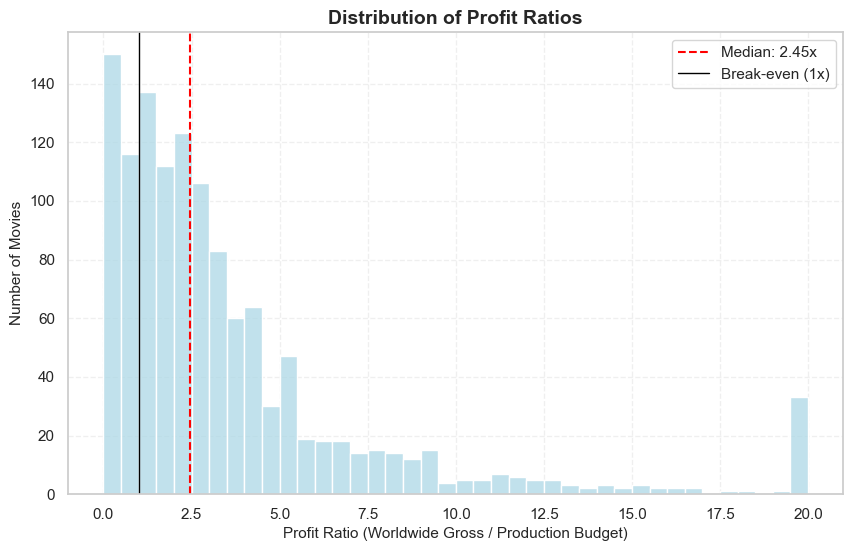

In [328]:
plt.figure(figsize=(10, 6))
sns.histplot(data_box['profit_ratio'], bins=40, color='lightblue')
plt.title('Distribution of Profit Ratios', fontsize=14, fontweight='bold')
plt.xlabel('Profit Ratio (Worldwide Gross / Production Budget)', fontsize=11)
plt.ylabel('Number of Movies', fontsize=11)
plt.axvline(data_box['profit_ratio'].median(), color='red', linestyle='--', 
            label=f'Median: {data_box["profit_ratio"].median():.2f}x')
plt.axvline(1, color='black', linestyle='-', linewidth=1, label='Break-even (1x)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


## Top 10 Studios by Average profit

C:\Users\HP\AppData\Local\Temp\ipykernel_22336\2790338702.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_studios.values, y=top_studios.index, palette='viridis')


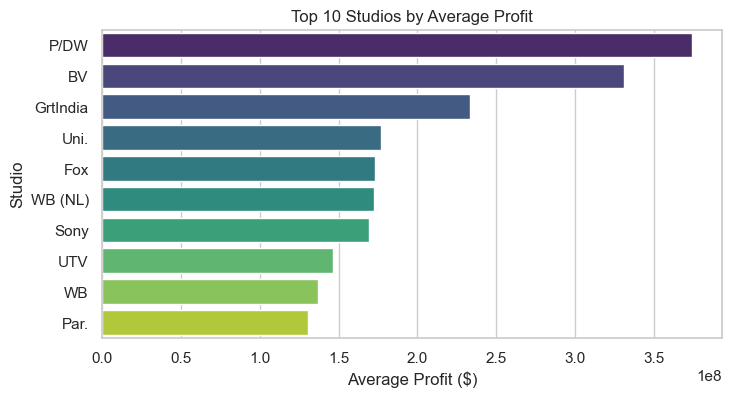

In [329]:
# compute total profit
data_box['profit'] = data_box['worldwide_gross'] - data_box['production_budget']

top_studios = data_box.groupby('studio')['profit'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(8,4))
sns.barplot(x=top_studios.values, y=top_studios.index, palette='viridis')

plt.title('Top 10 Studios by Average Profit')
plt.xlabel('Average Profit ($)')
plt.ylabel('Studio')
plt.show()

## Profit Distribution in top 5 studios

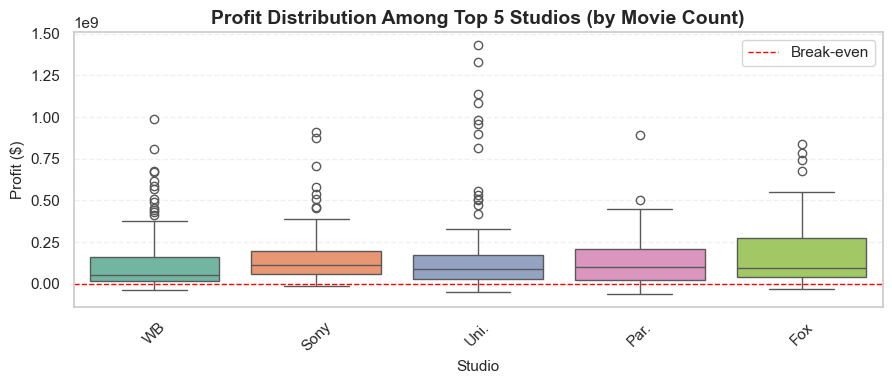

In [330]:
top5_studios = data_box['studio'].value_counts().head(5).index

plt.figure(figsize=(9, 4))
sns.boxplot(
    x='studio',
    y='profit',
    hue='studio',   # <-- Add this
    data=data_box[data_box['studio'].isin(top5_studios)],
    palette='Set2',
    legend=False    # <-- Hide the duplicate legend
)

plt.title('Profit Distribution Among Top 5 Studios (by Movie Count)', fontsize=14, fontweight='bold')
plt.xlabel('Studio', fontsize=11)
plt.ylabel('Profit ($)', fontsize=11)
plt.xticks(rotation=45)
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Break-even')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

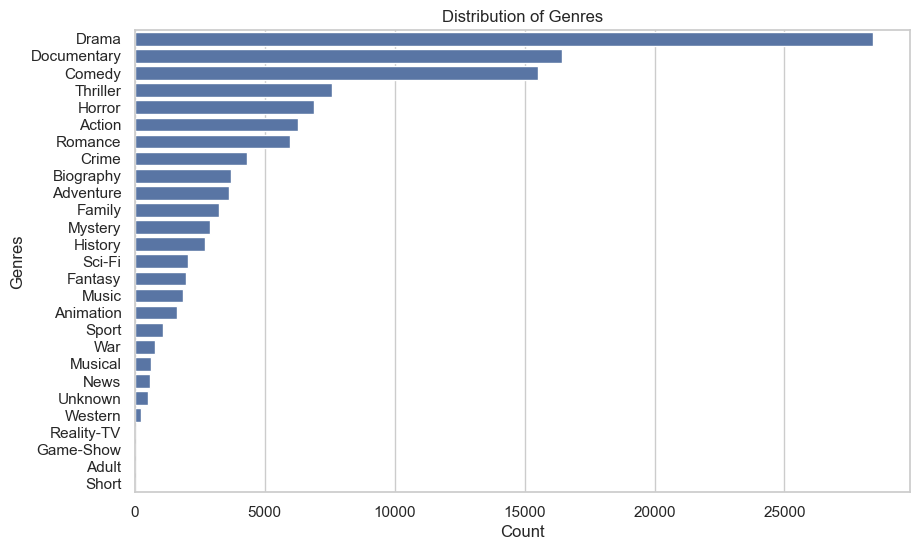

In [331]:
# Distribution of genres in our dataset
plt.figure(figsize=(10, 6))
movie_basics_and_rating_exploded = movie_basics_ratings['genres'].str.split(',').explode()
sns.countplot(y=movie_basics_and_rating_exploded, order=movie_basics_and_rating_exploded.value_counts().index)
plt.title('Distribution of Genres')
plt.xlabel('Count')
plt.ylabel('Genres')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_22336\1062651926.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='averagerating', y='genres', data=genre_avg_rating, palette='viridis')


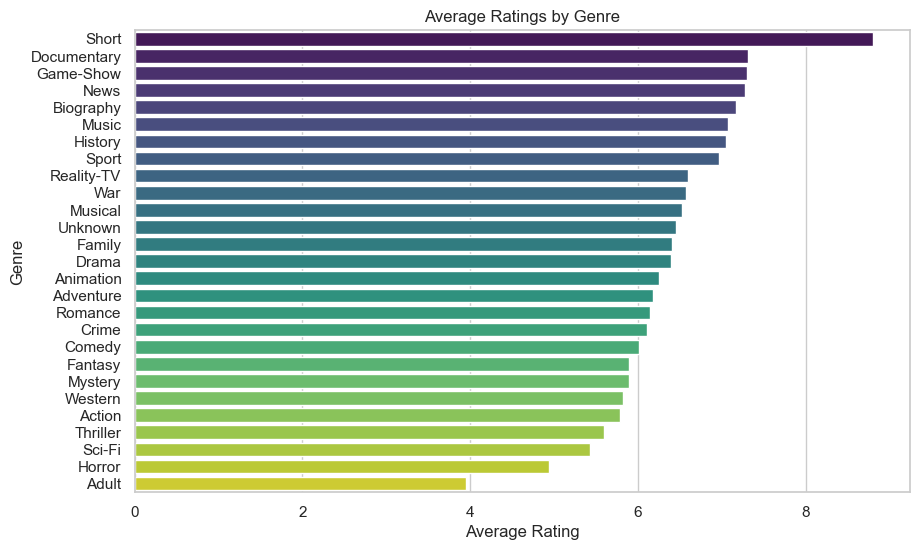

In [332]:
# Exploding genres to handle multiple genres per movie
movie_basics_ratings_exploded = movie_basics_ratings.assign(genres=movie_basics_ratings['genres'].str.split(',')).explode('genres')

# Calculating the average rating for each genre
genre_avg_rating = movie_basics_ratings_exploded.groupby('genres')['averagerating'].mean().reset_index().sort_values(by = 'averagerating', ascending=False)


# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='averagerating', y='genres', data=genre_avg_rating, palette='viridis')
plt.title('Average Ratings by Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.show()

# top genres by average rating

C:\Users\HP\AppData\Local\Temp\ipykernel_22336\3309913576.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_ratings.values, y=genre_ratings.index, palette='rocket')


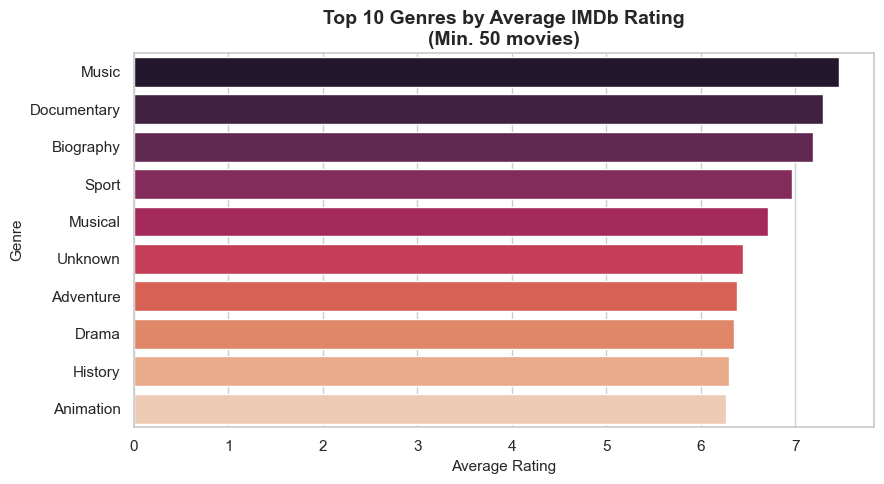

In [333]:
# Extract primary genre (first genre listed)
movie_basics_ratings['primary_genre'] = movie_basics_ratings['genres'].apply(lambda x: x.split(',')[0] if pd.notna(x) else 'Unknown')

# Filter genres with at least 50 movies
genre_counts = movie_basics_ratings['primary_genre'].value_counts()
valid_genres = genre_counts[genre_counts >= 50].index

genre_ratings = movie_basics_ratings[movie_basics_ratings['primary_genre'].isin(valid_genres)].groupby('primary_genre')['averagerating'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(9, 5))
sns.barplot(x=genre_ratings.values, y=genre_ratings.index, palette='rocket')
plt.title('Top 10 Genres by Average IMDb Rating\n(Min. 50 movies)', fontsize=14, fontweight='bold')
plt.xlabel('Average Rating', fontsize=11)
plt.ylabel('Genre', fontsize=11)
plt.tight_layout()
plt.show()

# What movies genres have been the most successful financially?
To answer this question, we look at the box office gross earnings and profits of various movies.

In [334]:
# check the top perfoming movies
top_20_movies_world=budgets.nlargest (n=20, columns='worldwide_gross')
top_20_movies_domestic = budgets.nlargest(n=20, columns ='domestic_gross')

C:\Users\HP\AppData\Local\Temp\ipykernel_22336\1131504704.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='worldwide_gross', y='movie', data=top_20_movies_world, ax=axes[0], palette='viridis')
C:\Users\HP\AppData\Local\Temp\ipykernel_22336\1131504704.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='domestic_gross', y='movie', data=top_20_movies_domestic, ax=axes[1], palette='magma')


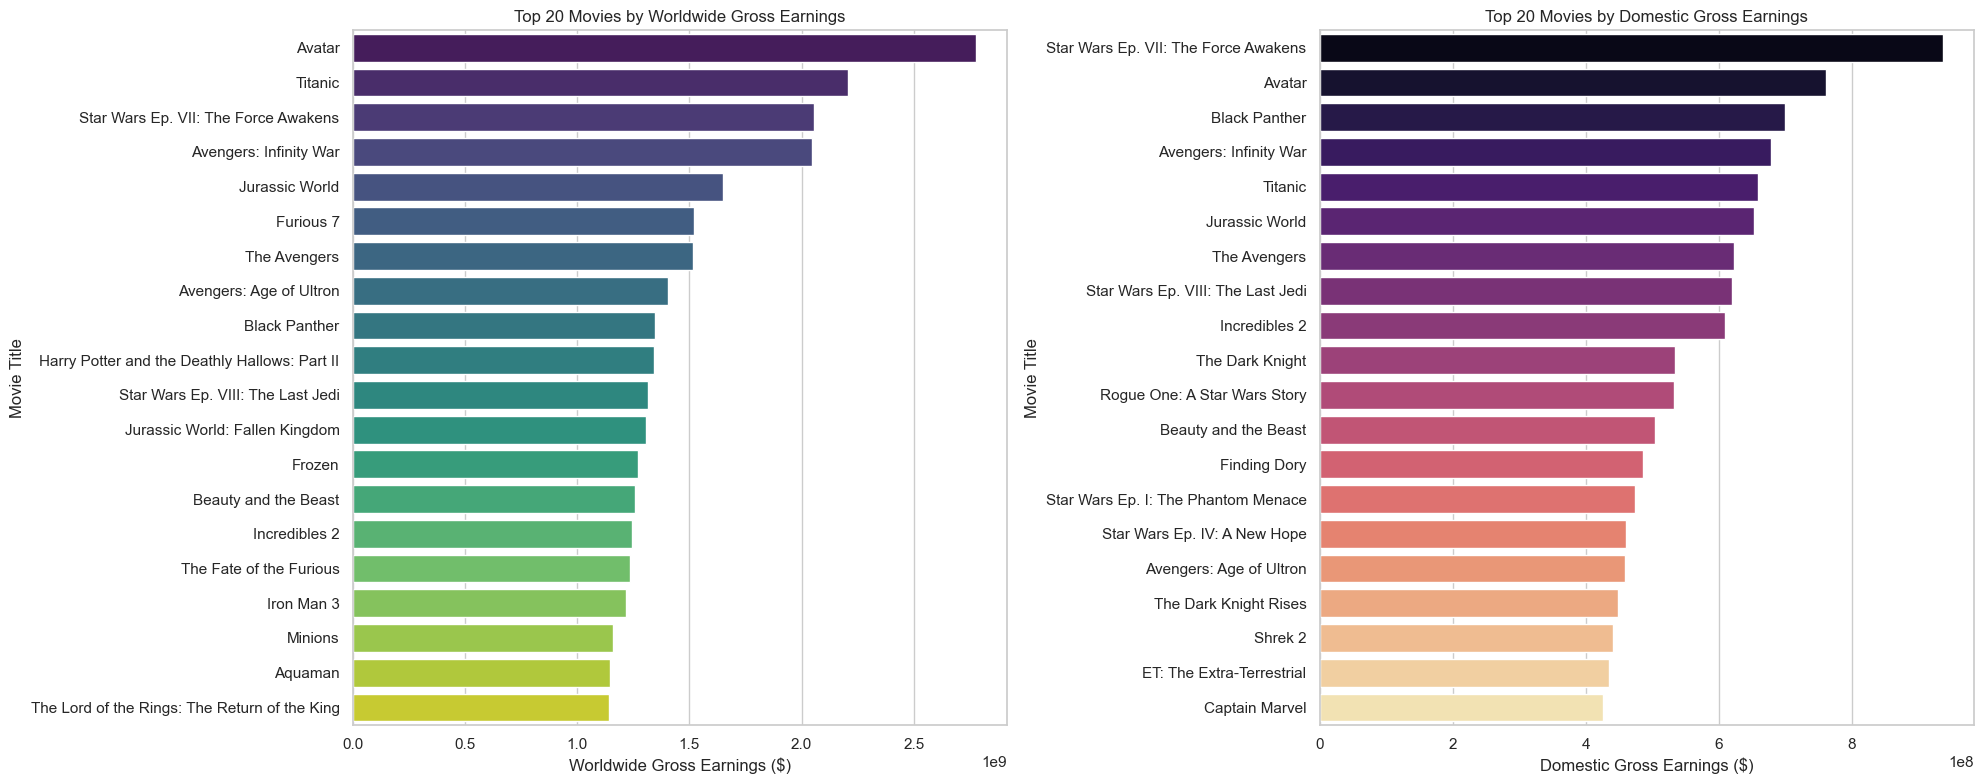

In [335]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot for worldwide gross earnings
sns.barplot(x='worldwide_gross', y='movie', data=top_20_movies_world, ax=axes[0], palette='viridis')
axes[0].set_xlabel('Worldwide Gross Earnings ($)')
axes[0].set_ylabel('Movie Title')
axes[0].set_title('Top 20 Movies by Worldwide Gross Earnings')

# Plot for domestic gross earnings
sns.barplot(x='domestic_gross', y='movie', data=top_20_movies_domestic, ax=axes[1], palette='magma')
axes[1].set_xlabel('Domestic Gross Earnings ($)')
axes[1].set_ylabel('Movie Title')
axes[1].set_title('Top 20 Movies by Domestic Gross Earnings')

# Adjust layout
plt.tight_layout()

# plt.savefig('top_20_movies_by_gross.png', dpi=300, bbox_inches='tight')

# Show the plots
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_22336\790241142.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='profit', y='movie', data=top_profitable, ax=ax, palette='viridis')


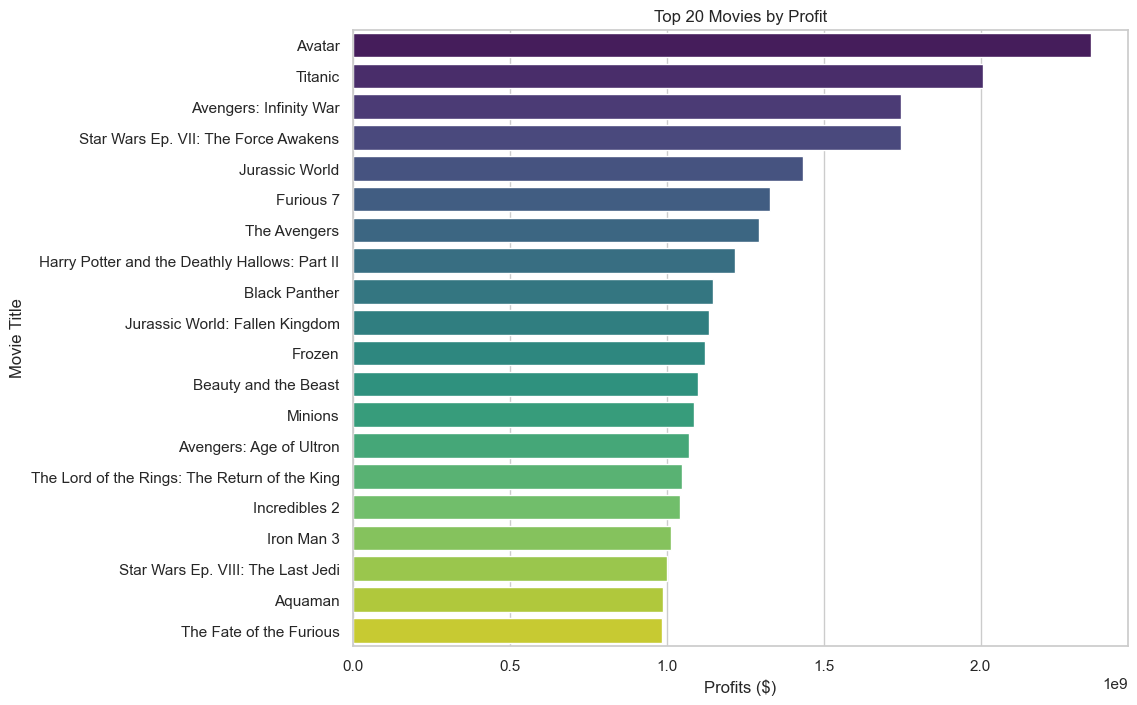

In [336]:
fig , ax = plt.subplots(figsize = (10,8))
# get the top 20 profitable movies
top_profitable = budgets.nlargest(n = 20, columns= 'profit')

sns.barplot(x='profit', y='movie', data=top_profitable, ax=ax, palette='viridis')

# Set axis labels and title
ax.set_xlabel('Profits ($)')
ax.set_ylabel('Movie Title')
plt.title('Top 20 Movies by Profit')

# plt.savefig('top_20_movies_by_profit.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

### Analysing the relationship between `domestic_gross`, `worlwide_gross` and `profit` 

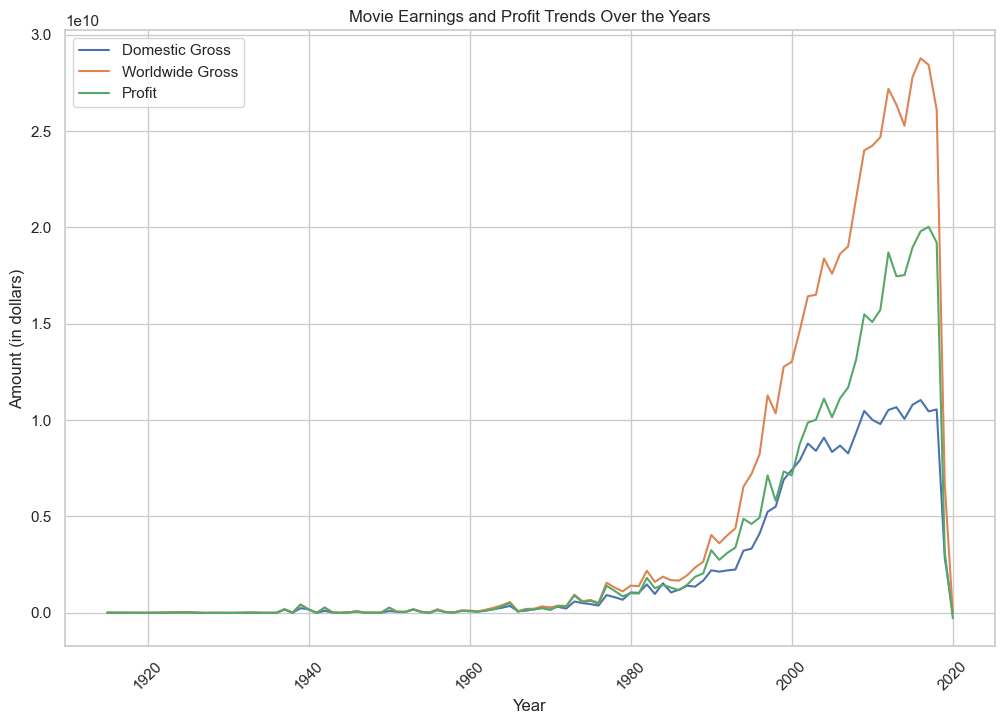

In [337]:
# plot movie earnings trends over the years and profits
# Aggregate data by year
yearly_data = budgets.groupby('release_year').agg({
    'domestic_gross': 'sum',
    'worldwide_gross': 'sum',
    'profit': 'sum'
}).reset_index()

# Plot the trends
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(data=yearly_data, x='release_year', y='domestic_gross', label='Domestic Gross', ax=ax)
sns.lineplot(data=yearly_data, x='release_year', y='worldwide_gross', label='Worldwide Gross', ax=ax)
sns.lineplot(data=yearly_data, x='release_year', y='profit', label='Profit', ax=ax)

ax.set_xlabel('Year')
ax.set_ylabel('Amount (in dollars)')
ax.set_title('Movie Earnings and Profit Trends Over the Years')
plt.xticks(rotation=45)
plt.legend()

plt.show()

Over time, we notice `domestic_gross`, `worldwide_gross` and `profit` have been generally increasing. 


To further understand `worldwide_gross`by month, we plot the average and total gross revenue by month. 

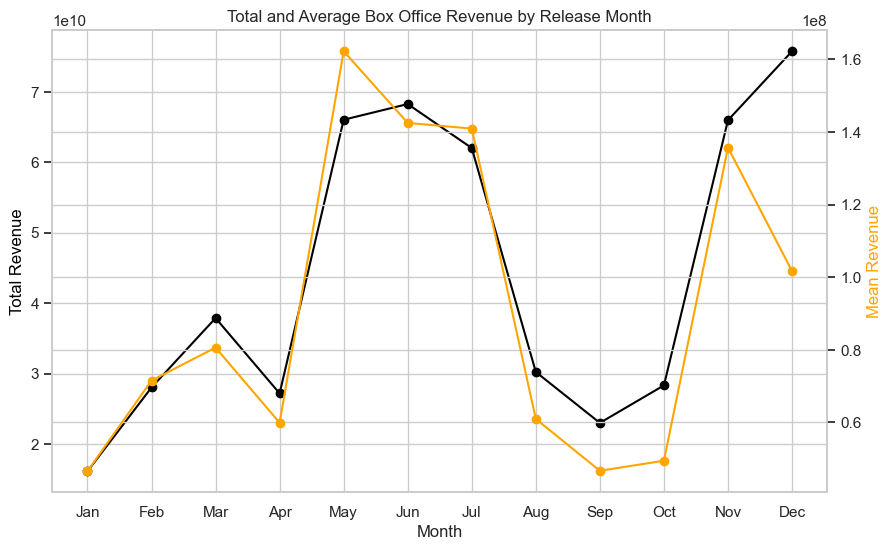

In [338]:
# Extract month number
budgets['month'] = budgets['release_date'].dt.month

# Now group by month and calculate total & average revenue
monthly_revenue = budgets.groupby('month')['worldwide_gross'].agg(['sum', 'mean']).reset_index()

# Plot
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.set_xlabel('Month')
ax1.set_ylabel('Total Revenue', color="black")
ax1.plot(monthly_revenue['month'].to_numpy(),
         monthly_revenue['sum'].to_numpy(),
         color="black", marker='o', label='Total Revenue')

ax2 = ax1.twinx()
ax2.set_ylabel('Mean Revenue', color="orange")
ax2.plot(monthly_revenue['month'].to_numpy(),
    monthly_revenue['mean'].to_numpy(),
    color="orange",
    marker='o',
    label='Mean Revenue')

plt.title('Total and Average Box Office Revenue by Release Month')
plt.xticks(monthly_revenue['month'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


From the above graph, we notice that while May, November and December have the highest revenues, on average, May, June and July are the highest performing.

C:\Users\HP\AppData\Local\Temp\ipykernel_22336\607423519.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=studio_gross, x='total_gross', y='studio', palette='cool')


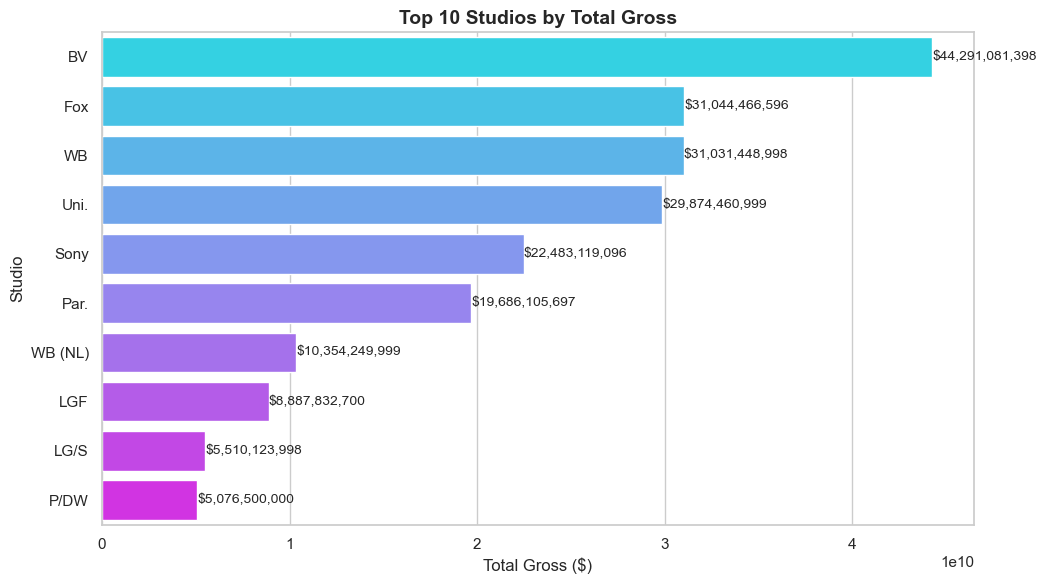

In [339]:
# total gross per studio
bom['total_gross'] = bom['domestic_gross'] + bom['foreign_gross']

studio_gross = (
    bom.groupby('studio')['total_gross']
       .sum()
       .sort_values(ascending=False)
       .head(10)
       .reset_index()
)

# Plot total gross for top 10 studios
plt.figure(figsize=(10,6))
sns.barplot(data=studio_gross, x='total_gross', y='studio', palette='cool')
plt.title('Top 10 Studios by Total Gross', fontsize=14, weight='bold')
plt.xlabel('Total Gross ($)')
plt.ylabel('Studio')
plt.tight_layout()

for i, v in enumerate(studio_gross['total_gross']):
    plt.text(v, i, f'${v:,.0f}', va='center', fontsize=10)

plt.show()


### popularity against ratings over time

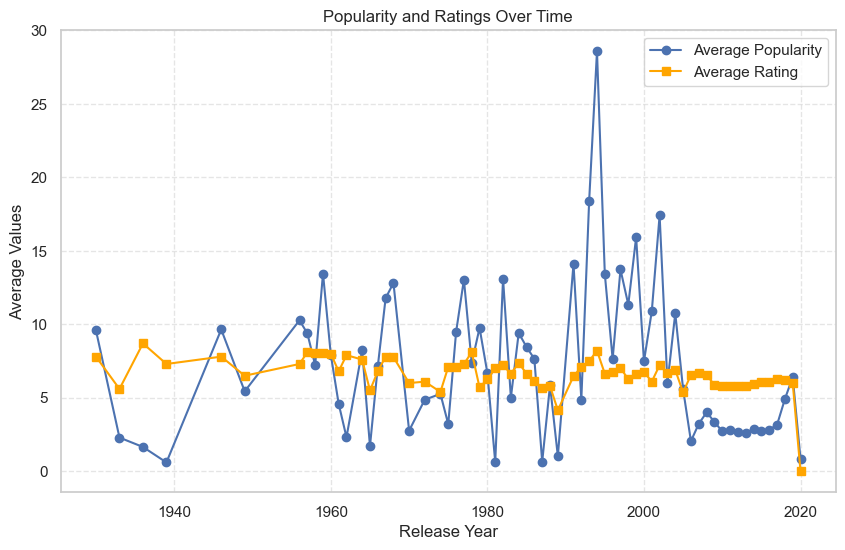

In [340]:
# Group by year and compute average popularity and rating
yearly_stats = tmdb.groupby('release_year')[['popularity', 'vote_average']].mean()

plt.figure(figsize=(10, 6))
plt.plot(yearly_stats.index.to_numpy(), yearly_stats['popularity'].to_numpy(), marker='o', label='Average Popularity')
plt.plot(yearly_stats.index.to_numpy(), yearly_stats['vote_average'].to_numpy(), marker='s', label='Average Rating', color='orange')

plt.title('Popularity and Ratings Over Time')
plt.xlabel('Release Year')
plt.ylabel('Average Values')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [341]:
yearly_stats.head()
yearly_stats.columns
type(yearly_stats.index)

pandas.core.indexes.base.Index

# Correlation between domestic and foreign earnings

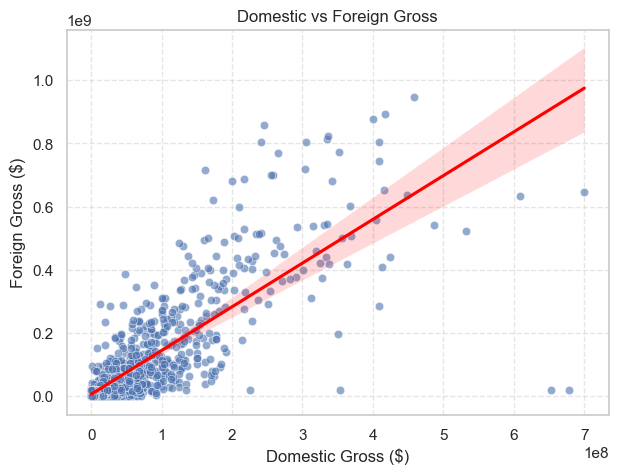

In [342]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='domestic_gross_y', y='foreign_gross', data=data_box, alpha=0.6)
sns.regplot(x='domestic_gross_y', y='foreign_gross', data=data_box, scatter=False, color='red')
plt.title('Domestic vs Foreign Gross')
plt.xlabel('Domestic Gross ($)')
plt.ylabel('Foreign Gross ($)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# Correlation heatmap
This shows how numeric features relate to each other

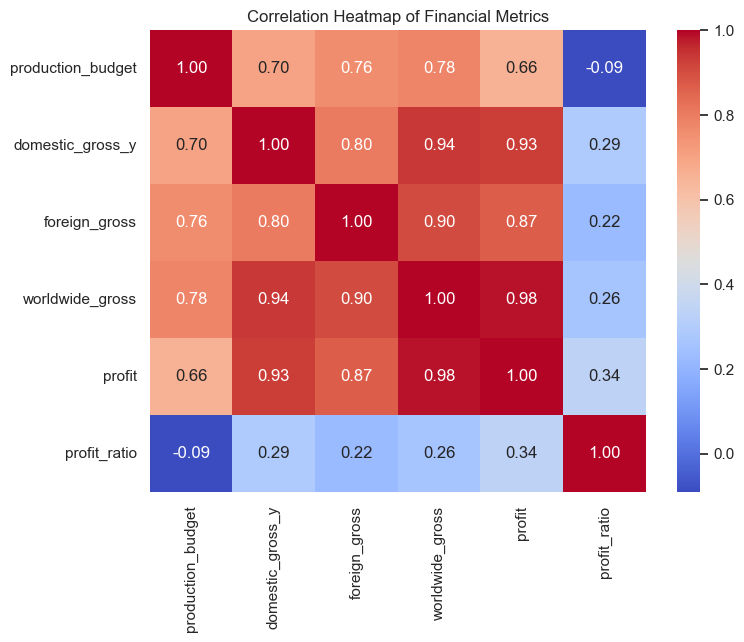

In [343]:
plt.figure(figsize=(8,6))
numeric_cols = ['production_budget', 'domestic_gross_y', 'foreign_gross', 'worldwide_gross', 'profit', 'profit_ratio']
sns.heatmap(data_box[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Financial Metrics')
plt.show()

This visualization quantifies the linear relationships between key financial metrics.

**Key Correlations:**
- **Production Budget & Worldwide Gross (0.78):** Strong positive correlation. Higher budgets are associated with higher revenues.
- **Domestic Gross & Worldwide Gross (0.94):** Very strong correlation. Domestic performance is a very good indicator of total global performance.
- **Profit & Worldwide Gross (0.98):** Near-perfect correlation, which is logical as profit is derived directly from gross and budget.
- **Profit Ratio & Production Budget (-0.09):** A very weak, slightly negative correlation. This is a critical insight: **spending more does not guarantee a better return on investment (ROI)**. Higher budgets lead to higher absolute profits but can often lead to less efficient returns.

# Statistical Hypothesis Testing

We conduct rigorous statistical tests to validate our observations.

# Hypothesis Test 1: Domestic vs. Foreign Gross

To check whether domestic gross is significantly different from foreign gross for the same movie

In [344]:
from scipy.stats import ttest_rel

t_stat, p_val = ttest_rel(data_box['domestic_gross_y'], data_box['foreign_gross'])
print("t-statistic:", t_stat)
print("p-value:", p_val)

print("                     ")
alpha = 0.05
if p_val < alpha:
    print("Reject the null hypothesis: Significant difference between domestic and foreign gross.")
else:
    print("Fail to reject the null hypothesis: No significant difference between domestic and foreign gross.")
    

t-statistic: -11.247984572985661
p-value: 5.065006802574202e-28
                     
Reject the null hypothesis: Significant difference between domestic and foreign gross.


- **Test:** Paired t-test (we have two measurements for the same movies).
- **Result:** p-value is extremely small (≈5e-28), far below 0.05.
- **Conclusion:** We reject the null hypothesis. There is a statistically significant difference between domestic and foreign gross. This confirms our EDA observation that the markets are distinct.
  
  
# Hypothesis Test 2: Studio Profitability


- **Null Hypothesis (H0):** The average profit is the same across the top 5 studios.
- **Alternative Hypothesis (H1):** At least one studio's average profit is different.

In [345]:
from scipy.stats import f_oneway

# Select top 5 studios by number of movies
top_studios = data_box['studio'].value_counts().head(5).index
profits_by_studio = [data_box[data_box['studio']==studio]['profit'] for studio in top_studios]

f_stat, p_val = f_oneway(*profits_by_studio)

print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.4f}")

print("             ")
alpha = 0.05
if p_val < alpha:
    print("Reject Null Hypothesis (H₀): There is a significant difference in average profits among the studio")
else:
    print("Fail to Reject Null Hypothesis (H₀): There is no significant difference in average profits among the studios.")


F-statistic: 0.9881
p-value: 0.4136
             
Fail to Reject Null Hypothesis (H₀): There is no significant difference in average profits among the studios.


- **Result:** p-value = 0.4136, which is greater than 0.05.
- **Conclusion:** We fail to reject the null hypothesis. There is no statistically significant evidence that the average profits of the top studios differ. This supports the box plot insight that studio brand alone isn't a major differentiator in average profitability.

## Hypothesis 3: High vs Low Budget Movie Profitability

**Null Hypothesis (H₀)**: High-budget and low-budget movies have the same average profit ratio.

**Alternative Hypothesis (H₁)**: High-budget and low-budget movies have different average profit ratios.

**Test**: Independent two-sample t-test

In [350]:
from scipy.stats import ttest_ind

# Define high and low budget categories (median split)
median_budget = data_box['production_budget'].median()
data_box['budget_category'] = data_box['production_budget'].apply(
    lambda x: 'High' if x >= median_budget else 'Low'
)

high_budget_ratio = data_box[data_box['budget_category'] == 'High']['profit_ratio']
low_budget_ratio = data_box[data_box['budget_category'] == 'Low']['profit_ratio']

# Conduct independent t-test
t_stat, p_val = ttest_ind(high_budget_ratio, low_budget_ratio)


print("HYPOTHESIS TEST 4: High vs Low Budget Movie Profitability")
print(" ")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_val:.4f}")
print("\nNull Hypothesis (H₀): There is no difference in profit ratios between high- and low-budget movies.")
print("Alternative Hypothesis (H₁): There is a significant difference in profit ratios between high- and low-budget movies.")


HYPOTHESIS TEST 4: High vs Low Budget Movie Profitability
 
t-statistic: -6.0565
p-value: 0.0000

Null Hypothesis (H₀): There is no difference in profit ratios between high- and low-budget movies.
Alternative Hypothesis (H₁): There is a significant difference in profit ratios between high- and low-budget movies.


 We reject the null hypothesis. There is a significant difference. The negative t-statistic indicates that the high-budget group has a lower average profit ratio than the low-budget group. This is a crucial finding: while big budgets make more money in absolute terms, they are less efficient in terms of ROI.





# Predictive Modeling

A simple linear regression model to predict worldwide gross.

In [352]:
# Prepare features for modeling

df_model = data_box[['production_budget', 'domestic_gross_y', 'foreign_gross', 'worldwide_gross']].dropna()
# This line selects only the 4 columns needed for modeling.
# .dropna() removes any rows that contain missing (NaN) values in any of these columns.

# Features and target
X = df_model[['production_budget']]
y = df_model['worldwide_gross']

# X (features) = the independent variable - production budget.
# y (target) = the dependent variable - worldwide gross revenue.

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 80% of data is used to train the model, 20% to test it.
# random_state=42 ensures reproducibility (same random split every time).

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("PREDICTIVE MODEL: Production Budget → Worldwide Gross")
print(" ")
print(f"Model: Linear Regression")
print(f"Features: Production Budget")
print(f"Target: Worldwide Gross")
print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"\nModel Performance:")
print(f"  R² Score: {r2:.4f}")
print(f"  RMSE: ${rmse/1e6:.2f}M")
print(f"\nRegression Equation:")
print(f"  Worldwide Gross = ${model.intercept_/1e6:.2f}M + {model.coef_[0]:.4f} × Budget")
print(f"\nInterpretation:")
print(f"  For every $1M increase in budget, worldwide gross increases by ${model.coef_[0]*1e6/1e6:.4f}M")


PREDICTIVE MODEL: Production Budget → Worldwide Gross
 
Model: Linear Regression
Features: Production Budget
Target: Worldwide Gross

Training samples: 996
Testing samples: 249

Model Performance:
  R² Score: 0.5796
  RMSE: $131.05M

Regression Equation:
  Worldwide Gross = $-4.23M + 3.3248 × Budget

Interpretation:
  For every $1M increase in budget, worldwide gross increases by $3.3248M


## Predictive Modeling: Budget to Gross Prediction
We build a simple linear regression model to predict a movie's worldwide gross based solely on its production budget.

**Model Performance:**
- **R² Score:** 0.58 - This means that 58% of the variance in worldwide gross can be explained by the production budget. It's a moderate fit, indicating that budget is a important, but not the only, factor in a movie's success.

- **RMSE:** $131.05 Million - On average, our model's predictions are off by about $131 million. This large error underscores the high uncertainty in the movie business.
- **Regression Equation:** `Worldwide Gross = -4.23M + 3.32 * Budget`
- **Interpretation:** For every additional $1 million spent on production, the model predicts an average increase of $3.32 million in worldwide gross. The negative intercept is a mathematical artifact of the model and not practically meaningful in this context.

**Conclusion:** Budget is a powerful predictor, but other factors (genre, star power, marketing, competition, release date) play a massive role in determining final box office performance.

<Figure size 900x500 with 0 Axes>

<Figure size 900x500 with 0 Axes>

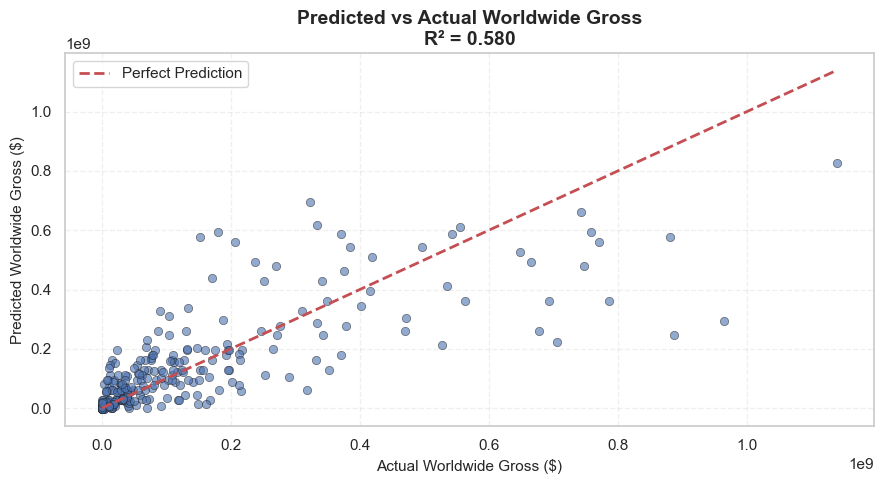

In [351]:
# Visualization
plt.figure(figsize=(9, 5))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
        'r--', linewidth=2, label='Perfect Prediction')
plt.title(f'Predicted vs Actual Worldwide Gross\nR² = {r2:.3f}', 
         fontsize=14, fontweight='bold')
plt.xlabel('Actual Worldwide Gross ($)', fontsize=11)
plt.ylabel('Predicted Worldwide Gross ($)', fontsize=11)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## Key Insights & Business Recommendations

### Summary of Validated Findings:
1.  **International is Key:** Foreign gross is significantly different and often larger than domestic gross.
2.  **The Budget Paradox:** Higher budgets lead to higher absolute profits but lower Return on Investment (ROI). Mid-budget films often offer the best risk-reward balance.
3.  **Studio is Not a Destiny:** No significant difference in average profit among top studios. Focus on the project, not just the studio logo.
4.  **Genre Matters for Ratings:** Genres have significantly different audience ratings, which can inform marketing and critical expectations.

### Actionable Recommendations:
- **For Producers:** Target mid-range budgets for optimal ROI and prioritize international appeal in story and marketing.
- **For Investors:** Diversify across genres and budgets; evaluate projects based on profit ratio, not just potential total gross.
- **For Marketers:** Tailor campaigns for domestic and international audiences separately and leverage high ratings when available for genres like Documentary or Drama.